# Homework 2
James Larsen

PHYSICS 514 -- Emmanuel Gull

In [81]:
import numpy as np
from matplotlib import pyplot as plt
from time import time

## Finite Difference

Discretizing the Poisson equation in two space dimensions yields the following system of linear equations:
\begin{equation}
\Phi(x_{n+1},y_m) + \Phi(x_{n-1},y_m) + \Phi(x_n,y_{m+1}) + \Phi(x_n,y_{m-1}) - 4\Phi(x_n,y_m) = -4\pi \rho(x_n,y_m) \Delta x^2.
\end{equation}
Manipulating this equation gives us the following iterative method:
\begin{equation}
\Phi_{k+1}(x_n,y_m) \leftarrow \frac{1}{4}\left[ \Phi(x_{n+1},y_m) + \Phi(x_{n-1},y_m) + \Phi(x_n,y_{m+1}) + \Phi(x_n,y_{m-1}) + 4\pi \rho(x_n,y_m) \Delta x^2 \right].
\end{equation}

In [139]:
def finite_diff(dx, Phi_j, tol, ρs):
    '''
    Solve Poisson equation using finite difference iteration
    
    dx:     discretization step size
    Phi_j:  initial guess
    tol:    error tolerance
    ρs:     charge density
    
    returns solution (Phi_j) and number of iterations to solution (j)
    '''  
    # iterate until converged
    ϵ = 1
    j = 0
    while ϵ > tol:
        Phi_next = np.copy(Phi_j)
        for n in range(1, Phi_j.shape[0]-1):
            for m in range(1, Phi_j.shape[1]-1): 
                Phi_next[n,m] = (Phi_j[n+1,m] + Phi_j[n-1,m] + Phi_j[n,m+1] + Phi_j[n,m-1] + 4*np.pi*ρs[n,m]*dx**2) / 4
        ϵ = np.linalg.norm(Phi_next - Phi_j)
        Phi_j = Phi_next
        j += 1
    
    # return desired values
    return Phi_j, j

In [149]:
def iteration(σ):
    '''
    repeat iterative method for specified value of σ
    '''
    # initialize global values
    ks = np.arange(2,6)
    dxs = 1 / (2**ks)
    numiters_fd = np.zeros(len(dxs))
    times_fd = np.zeros(len(dxs))

    # loop over discretizations
    for i, dx in enumerate(dxs):
        x = np.arange(0, 1+dx, dx)
        y = np.arange(0, 1+dx, dx)
        xs, ys = np.meshgrid(x, y, sparse=True)
        ρs = np.exp(-( (xs-0.25)**2 + (ys-0.75)**2 ) / (2*σ**2)) / (σ * np.sqrt(2*np.pi))
        tol = 1e-8

        # initialize Phi to satisfy boundary conditions
        Phi_j = np.zeros(ρs.shape)
        Phi_j[:,0] = x
        Phi_j[:,-1] = x
        Phi_j[-1] = np.ones(len(x))

        # solve via finite difference iteration
        start = time()
        Phi_j, numiters_fd[i] = finite_diff(dx, Phi_j, tol, ρs)
        end = time()
        times_fd[i] = end-start
    
    # return values
    return ρs, Phi_j, numiters_fd, times_fd

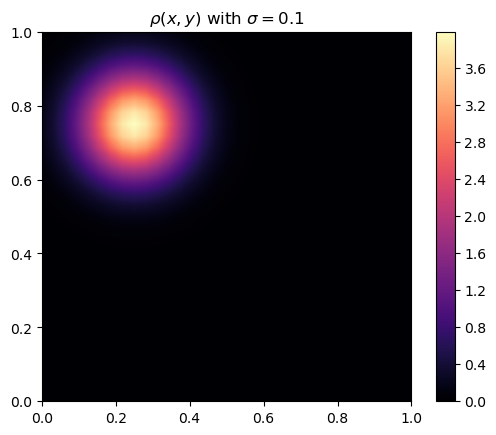

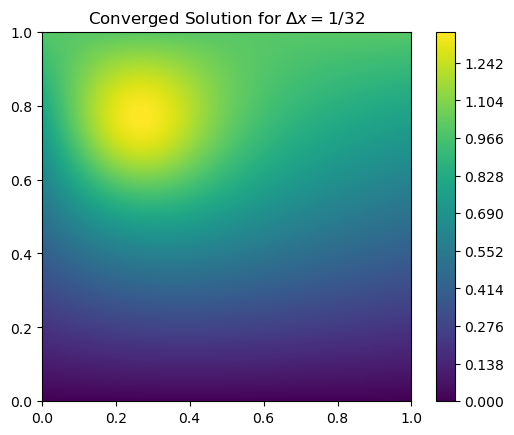

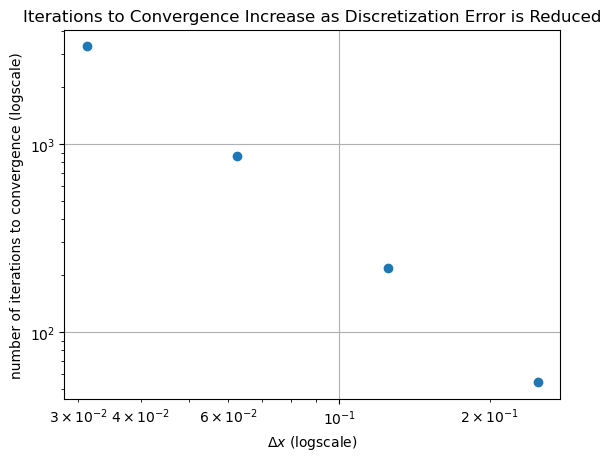

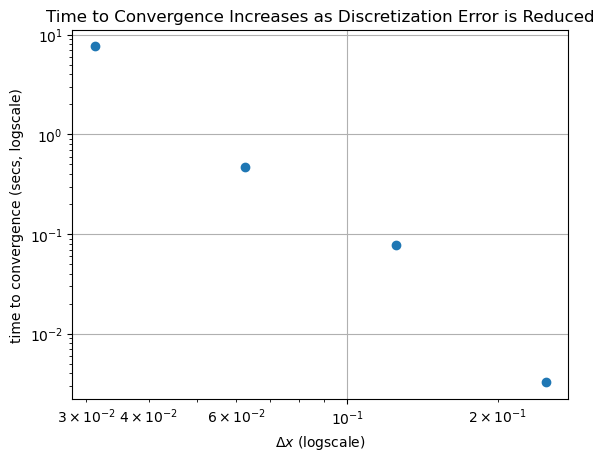

In [144]:
# get values
ρs, Phi_j, numiters_fd, times_fd = iteration(0.1)

# plot result
plt.contourf(x, y, ρs, levels=500, cmap="magma")
plt.axis('scaled')
plt.title(r"$\rho(x,y)$ with $\sigma = 0.1$")
plt.colorbar()
plt.show()

# plot result
plt.contourf(x, y, Phi_j, levels=500)
plt.axis('scaled')
plt.title(r"Converged Solution for $\Delta x = 1/32$")
plt.colorbar()
plt.show()

# plot number of iterations to convergence
plt.scatter(dxs, numiters_fd)
plt.xscale("log")
plt.xlabel(r"$\Delta x$ (logscale)")
plt.ylabel("number of iterations to convergence (logscale)")
plt.yscale("log")
plt.title("Iterations to Convergence Increase as Discretization Error is Reduced")
plt.grid()
plt.show()

# plot time to convergence
plt.scatter(dxs, times_fd)
plt.xscale("log")
plt.xlabel(r"$\Delta x$ (logscale)")
plt.ylabel("time to convergence (secs, logscale)")
plt.yscale("log")
plt.title("Time to Convergence Increases as Discretization Error is Reduced")
plt.grid()
plt.show()

## Over-relaxation

To speed up convergence, we can use multi-grid methods. The general method is given by the following steps:

1. Solve the Poisson equation on a grid with spacing $\Delta x$.
2. Refine the grid $\Delta x \leftarrow \Delta x/2$.
3. Interpolate the potential at the new grid points.
4. Repeat until the desired final fine grid spacing is reached.

In [147]:
def multigrid(σ):
    '''
    repeat multi-grid method for specified value of σ
    '''
    # initialize global values
    ks = np.arange(2,6)
    dxs = 1 / (2**ks)
    numiters_mg = np.zeros(len(dxs))
    times_mg = np.zeros(len(dxs))
    tol = 1e-8

    # loop over discretizations
    for i, dx in enumerate(dxs):

        # initialize very coarse mesh
        dx_curr = 1 / 2

        # loop until desired grid spacing reached
        start = time()
        while dx_curr != dx:
            dx_curr /= 2

            # initialize grid and charge density
            x = np.arange(0, 1+dx_curr, dx_curr)
            y = np.arange(0, 1+dx_curr, dx_curr)
            xs, ys = np.meshgrid(x, y, sparse=True)
            ρs = np.exp(-( (xs-0.25)**2 + (ys-0.75)**2 ) / (2*σ**2)) / (σ * np.sqrt(2*np.pi))

            # initialize Phi to satisfy boundary conditions
            Phi_new = np.zeros(ρs.shape)
            Phi_new[:,0] = x
            Phi_new[:,-1] = x
            Phi_new[-1] = np.ones(len(x))

            # interpolate potential if not first iteration
            if dx_curr != 1/4:
                Phi_new[::2,::2] = Phi_j
                Phi_new[::2,1::2] = (Phi_j[:,:-1:] + Phi_j[:,1::]) / 2
                Phi_new[1::2,::2] = (Phi_j[:-1:,:] + Phi_j[1::,:]) / 2
                Phi_new[1::2, 1::2] = (Phi_new[1::2,:-1:2] + Phi_new[1::2,2::2]) / 2

            # solve via finite difference iteration
            Phi_j, numiters_fd_curr = finite_diff(dx, Phi_new, tol, ρs)
            numiters_mg[i] += numiters_fd_curr

        # add times
        end = time()
        times_mg[i] = end-start
    
    # return values
    return ρs, Phi_j, numiters_mg, times_mg

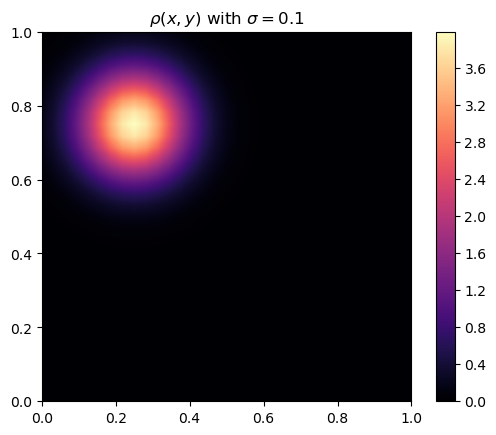

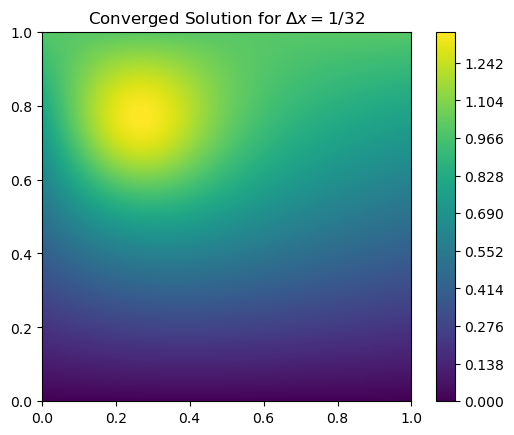

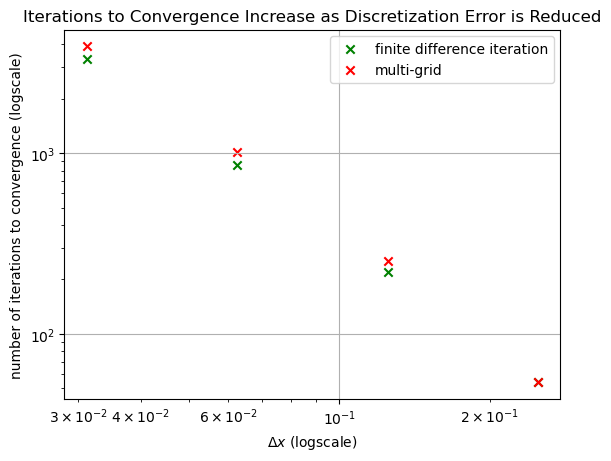

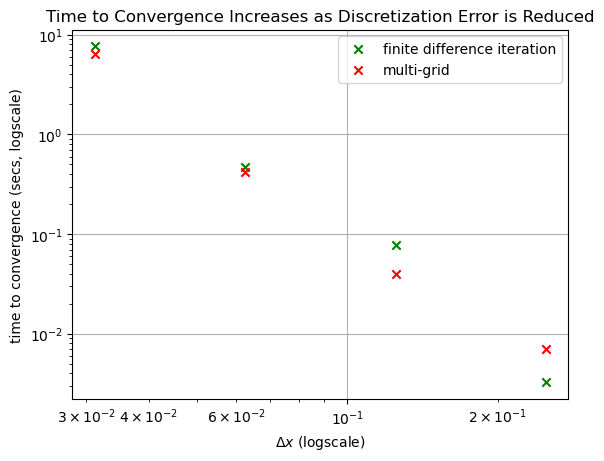

In [148]:
# get values
ρs, Phi_j, numiters_mg, times_mg = multigrid(0.1)

# plot result
plt.contourf(x, y, ρs, levels=500, cmap="magma")
plt.axis('scaled')
plt.title(r"$\rho(x,y)$ with $\sigma = 0.1$")
plt.colorbar()
plt.show()

# plot result
plt.contourf(x, y, Phi_j, levels=500)
plt.axis('scaled')
plt.title(r"Converged Solution for $\Delta x = 1/32$")
plt.colorbar()
plt.show()

# plot number of iterations to convergence
plt.scatter(dxs, numiters_fd, marker="x", color="green", label="finite difference iteration")
plt.scatter(dxs, numiters_mg, marker="x", color="red", label="multi-grid")
plt.xscale("log")
plt.xlabel(r"$\Delta x$ (logscale)")
plt.ylabel("number of iterations to convergence (logscale)")
plt.yscale("log")
plt.title("Iterations to Convergence Increase as Discretization Error is Reduced")
plt.grid()
plt.legend(loc="best")
plt.show()

# plot time to convergence
plt.scatter(dxs, times_fd, marker="x", color="green", label="finite difference iteration")
plt.scatter(dxs, times_mg, marker="x", color="red", label="multi-grid")
plt.xscale("log")
plt.xlabel(r"$\Delta x$ (logscale)")
plt.ylabel("time to convergence (secs, logscale)")
plt.yscale("log")
plt.title("Time to Convergence Increases as Discretization Error is Reduced")
plt.grid()
plt.legend(loc="best")
plt.show()

Note that while the overall number of iterations increases for the multi-grid methods in comparison to the standard finite difference with iteration, the wall clock time for smaller $\Delta x$  decreases. This result reflects the fact that more iterations are performed on easier coarse grids with fewer points. The convergence criterion for this iterative method is chosen to be $||\Phi_{k-1} - \Phi_k|| < 10^{-8}$, thus the method does not require a known solution a priori.

## Comparative Results

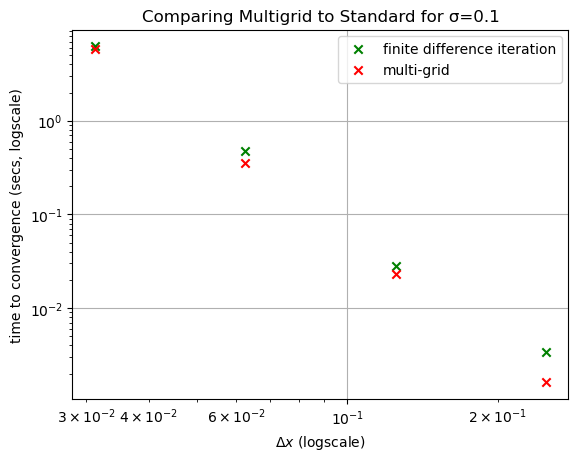

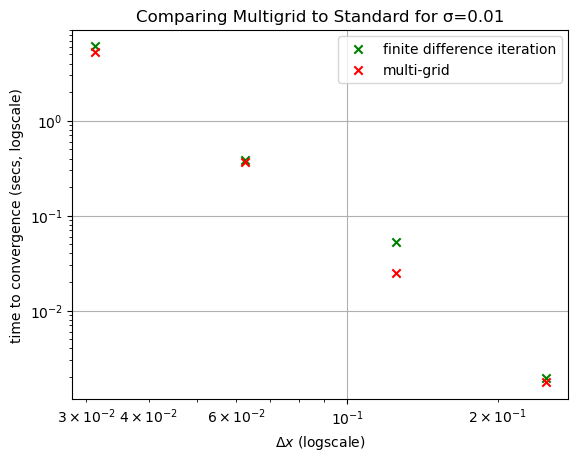

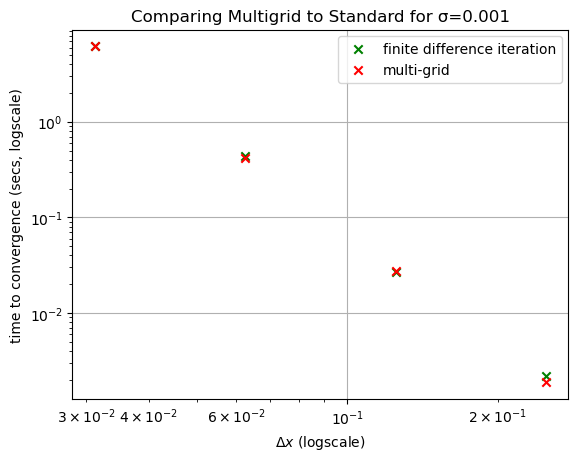

In [152]:
σs = [0.1, 0.01, 0.001]
for i, σ in enumerate(σs):
    _, _, _, times_fd = iteration(σ)
    _, _, _, times_mg = multigrid(σ)
    plt.scatter(dxs, times_fd, marker="x", color="green", label=fr"finite difference iteration")
    plt.scatter(dxs, times_mg, marker="x", color="red", label=fr"multi-grid")

    # format and show
    plt.xscale("log")
    plt.xlabel(r"$\Delta x$ (logscale)")
    plt.ylabel("time to convergence (secs, logscale)")
    plt.yscale("log")
    plt.title(f"Comparing Multigrid to Standard for σ={σ}")
    plt.grid()
    plt.legend(loc="best")
    plt.show()

In the above plots, we see that the advantage of multi-grid is more evident for larger choices of $\sigma$. This fact makes sense: smaller $\sigma$ requires a finer grid to refine the tightly concentrated potential, hence the coarse grid steps in the multi-grid method will not alleviate as much computational work for the later finer iterations.